<!--
 * @file        7_kalman_filter.ipynb
 * @brief       This notebook provides Kalman Filter practice.
 *
 * @authors     Jaehwan Lee (idljh5529@gmail.com)
 *
 * @date        2025-08-13 Released by AI Lab, Hanyang University
 *
-->

# 7. Kalman Filter

이번 실습에서는 자율주행 차량의 상태 추정에 핵심적인 **칼만 필터(Kalman Filter)**에 대해 학습합니다.

## 실습 목표
1. **칼만 필터 이론**: 예측-업데이트 과정과 수학적 원리 이해
2. **CA 모션 모델**: 등가속도 운동 모델 기반 차량 동역학 모델링
3. **불안정 시스템**: 측정 없이 예측만 할 때의 불확실성 증가 분석
4. **상태 추정**: 인지 센서 측정을 활용한 차량 위치 및 속도 추정
5. **성능 비교**: 단순 전파 vs. 칼만 필터의 추정 성능 비교

## 칼만 필터의 중요성

### 1. 자율주행에서의 역할
- **센서 융합**: 다양한 센서 정보를 통합하여 정확한 상태 추정
- **노이즈 필터링**: 센서 측정 노이즈를 효과적으로 제거
- **예측과 보정**: 동역학 모델 기반 예측과 측정 기반 보정의 최적 결합
- **실시간 처리**: 효율적인 연산으로 실시간 상태 추정 가능

### 2. 불안정 시스템의 특성
- **발산 특성**: 측정 없이는 불확실성이 지속적으로 증가
- **관측 가능성**: 시스템 상태가 측정을 통해 추정 가능한지 판단
- **칼만 필터의 안정화**: 적절한 측정을 통해 불안정한 시스템도 안정화

### 3. CA (Constant Acceleration) 모델
- **2차 동역학**: 위치, 속도에 더해 가속도까지 고려
- **차량 동역학**: 실제 차량의 운동을 잘 모사하는 모델
- **입력 처리**: 가속도 입력을 통한 제어 고려

## 실습 내용
- **시뮬레이션 데이터**: 12초간의 2D 차량 운동 시뮬레이션
- **인지 센서 측정**: 0.6초마다 객체 위치 측정 (노이즈 포함)
- **상태 벡터**: [x, y, vx, vy] (위치와 속도)
- **측정 벡터**: [x_meas, y_meas] (측정된 위치)

## 사용할 라이브러리
- **NumPy**: 수치 연산 및 행렬 계산
- **Matplotlib**: 결과 시각화 및 애니메이션
- **SciPy**: 수치 적분 및 과학 계산

In [1]:
# 외부에 정의된 파이썬 모듈(.py 파일)을 수정할 때마다 매번 커널을 재시작하지 않아도 변경 사항이 자동으로 반영되도록 설정
%load_ext autoreload
%autoreload 2

In [2]:
# 필요한 라이브러리 임포트
import sys
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 사용자 정의 시각화 모듈 임포트
sys.path.append('./tutlibs/kalman_filter')
from tutlibs.kalman_filter.custom_kalman_filter import (
    KalmanFilterVisualizer
)

print("라이브러리 임포트 완료!")
print("Python 버전:", sys.version)
print("NumPy 버전:", np.__version__)
print("Matplotlib 버전:", plt.matplotlib.__version__)


라이브러리 임포트 완료!
Python 버전: 3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]
NumPy 버전: 2.2.6
Matplotlib 버전: 3.10.5


# 1. 문제 상황

<img src="../resources/ch7/kalman_filter_explain.png" width="50%">  

A vehicle is moving on a 2D plane. The initial conditions for the vehicle's state are given as follows:  
- **Initial position** 𝑥 follows a normal distribution **𝑁 (0 m,1 m)**.  
- **Initial position** 𝑦 follows a normal distribution **𝑁 (0 m,1 m)**.  
- **Initial velocity** 𝑣𝑥 follows a normal distribution **𝑁 (4 m/s,1 m/s)**.  
- **Initial velocity** 𝑣𝑦 follows a normal distribution **𝑁 (2 m/s,1 m/s)**.  


We measure the vehicle's position with object detection sensor.

The object detection sensor measurement are given as follows:

- Position measurement **z** follows a normal distribution $𝑁 ([x, y]ᵀ, diag([1.0^2 1.0^2] m)$.

Estimate the motion of the vehicle over time and plot the position and covariance on the 2D plane.

## 2. 차량 시뮬레이션 데이터 생성

차량이 2D 평면에서 다음과 같은 조건으로 운동합니다:

### 초기 조건
- **위치**: x₀ = 0m, y₀ = 0m  
- **속도**: vₓ₀ = 4m/s, vᵧ₀ = 2m/s
- **총 시뮬레이션 시간**: 12초

### 가속도 입력 패턴
- **X 방향**: 0-4초(+2m/s²) → 4-8초(-4m/s²) → 8-12초(+2m/s²)
- **Y 방향**: 0-3초(+3m/s²) → 3-6초(-6m/s²) → 6-9초(+4m/s²) → 9-12초(0m/s²)

### 인지 센서 설정
- **측정 주기**: 0.6초마다 (6 × 0.1s)
- **측정 노이즈**: σ = 1.0m (가우시안 분포)


=== 시뮬레이션 데이터 정보 ===
총 시간: 11.9초
샘플 수: 120개
샘플링 주기: 0.1초
인지 센서 측정 주기: 6 샘플 = 0.6000000000000001초
인지 센서 노이즈 표준편차: 1.0m

=== 운동 범위 ===
X 위치 범위: 0.0 ~ 47.8 m
Y 위치 범위: 0.0 ~ 34.0 m
X 속도 범위: -4.2 ~ 11.8 m/s
Y 속도 범위: -7.3 ~ 10.7 m/s
=== 차량 운동 데이터 시각화 ===


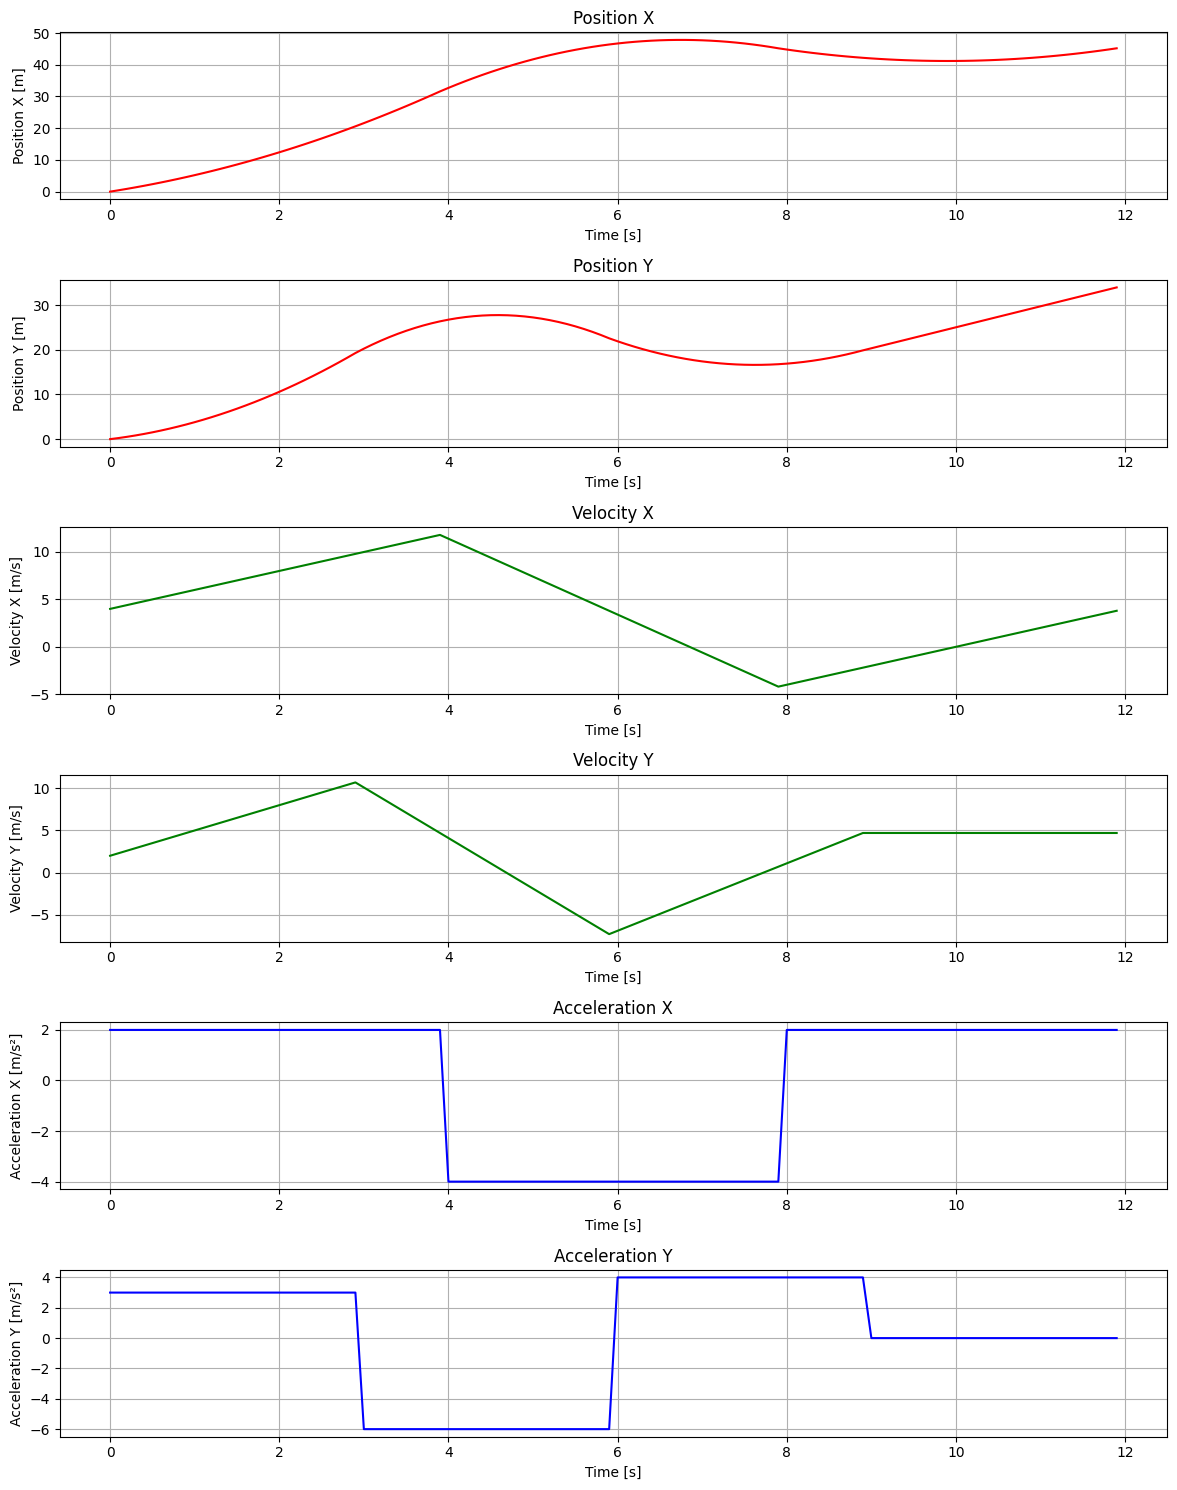

In [8]:
# 차량 시뮬레이터 생성 및 데이터 생성
dt = 0.1
total_time = 12
n_step = total_time / dt
time = np.arange(0, total_time, dt)

# 초기 조건
initial_position_x = 0
initial_position_y = 0
initial_velocity_x = 4
initial_velocity_y = 2
initial_acceleration_x = 2
initial_acceleration_y = 3

# 가속도 입력 생성
steps_4s = int(4 / dt)  # 4초 동안의 스텝 수
steps_3s = int(3 / dt)  # 3초 동안의 스텝 수

acceleration_x = np.concatenate([
    np.full(steps_4s, initial_acceleration_x),  # 0-4초: +2 m/s²
    np.full(steps_4s, -4),                      # 4-8초: -4 m/s²
    np.full(steps_4s, 2)                        # 8-12초: +2 m/s²
])

acceleration_y = np.concatenate([
    np.full(steps_3s, initial_acceleration_y),
    np.full(steps_3s, -6),
    np.full(steps_3s, 4),
    np.full(steps_3s, 0)
])

# 속도 계산
velocity_x = np.zeros(len(time))
velocity_y = np.zeros(len(time))
position_x = np.zeros(len(time))
position_y = np.zeros(len(time))

for i in range(len(time)):
    if i == 0:
        velocity_x[i] = initial_velocity_x
        velocity_y[i] = initial_velocity_y
        position_x[i] = initial_position_x
        position_y[i] = initial_position_y
    else:
        velocity_x[i] = velocity_x[i-1] + acceleration_x[i] * dt # TODO: 속도 계산 - i-1번째 속도에 i번째 가속도 적용
        velocity_y[i] = velocity_y[i-1] + acceleration_y[i] * dt # TODO: 속도 계산 - i-1번째 속도에 i번째 가속도 적용
        position_x[i] = position_x[i-1] + velocity_x[i] * dt + 0.5 * acceleration_x[i] * dt * dt # TODO: 위치 계산 - i-1번째 위치에 i번째 속도 적용
        position_y[i] = position_y[i-1] + velocity_y[i] * dt + 0.5 * acceleration_y[i] * dt * dt # TODO: 위치 계산 - i-1번째 위치에 i번째 속도 적용


# 인지 센서 측정 노이즈 표준편차
detection_measurement_noise_sigma = 1.0  # 1.0m
# 인지 센서 측정 주기
detection_measurement_update_interval = 6  # 0.6초마다 업데이트 (6 * 0.1s)
# 인지 센서 측정 데이터 생성
detection_measurement_x = position_x + np.random.normal(0, detection_measurement_noise_sigma, len(position_x))
detection_measurement_y = position_y + np.random.normal(0, detection_measurement_noise_sigma, len(position_y))
# (2, 120) 형태의 measurement 데이터 생성
detection_measurement = np.array([detection_measurement_x, detection_measurement_y])

# 시뮬레이션 데이터 저장
sim_data = {
    'time': time,
    'position_x': position_x,
    'position_y': position_y,
    'velocity_x': velocity_x,
    'velocity_y': velocity_y,
    'acceleration_x': acceleration_x,
    'acceleration_y': acceleration_y,
    'detection_measurement_x': detection_measurement_x,
    'detection_measurement_y': detection_measurement_y,
    'detection_update_interval': detection_measurement_update_interval,
    'detection_noise_sigma': detection_measurement_noise_sigma
}

print("=== 시뮬레이션 데이터 정보 ===")
print(f"총 시간: {sim_data['time'][-1]:.1f}초")
print(f"샘플 수: {len(sim_data['time'])}개")
print(f"샘플링 주기: {dt}초")
print(f"인지 센서 측정 주기: {sim_data['detection_update_interval']} 샘플 = {sim_data['detection_update_interval'] * dt}초")
print(f"인지 센서 노이즈 표준편차: {sim_data['detection_noise_sigma']}m")

# 기본 정보 출력
print(f"\n=== 운동 범위 ===")
print(f"X 위치 범위: {np.min(sim_data['position_x']):.1f} ~ {np.max(sim_data['position_x']):.1f} m")
print(f"Y 위치 범위: {np.min(sim_data['position_y']):.1f} ~ {np.max(sim_data['position_y']):.1f} m")
print(f"X 속도 범위: {np.min(sim_data['velocity_x']):.1f} ~ {np.max(sim_data['velocity_x']):.1f} m/s")
print(f"Y 속도 범위: {np.min(sim_data['velocity_y']):.1f} ~ {np.max(sim_data['velocity_y']):.1f} m/s")

# 시뮬레이션 데이터 시각화
visualizer = KalmanFilterVisualizer()
print("=== 차량 운동 데이터 시각화 ===")
visualizer.plot_simulation_data(sim_data)

=== 2D 궤적 및 인지 센서 측정 시각화 ===


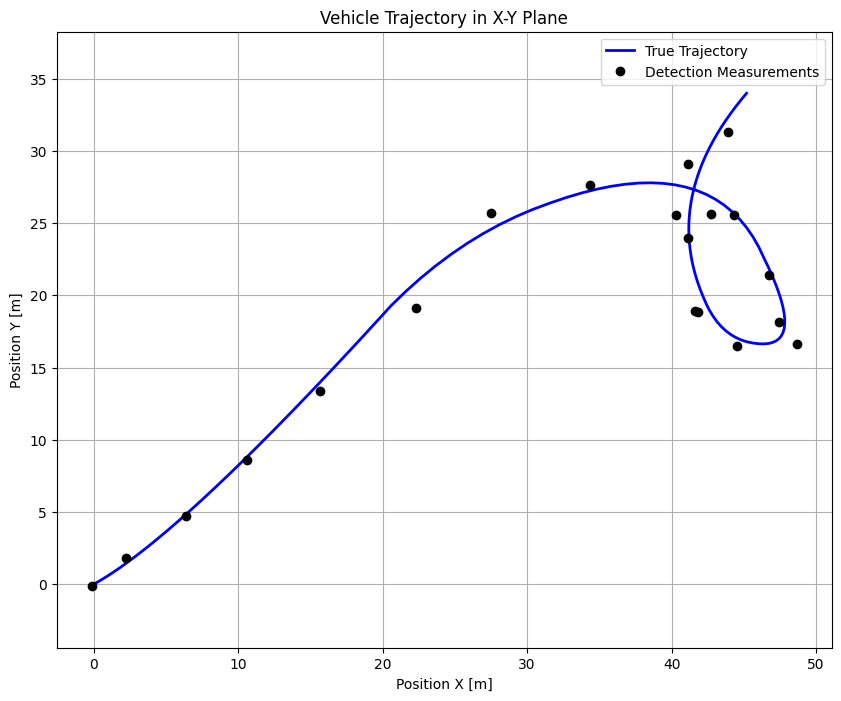

In [9]:
# 2D 궤적 및 인지 센서 측정값 시각화
print("=== 2D 궤적 및 인지 센서 측정 시각화 ===")
visualizer.plot_trajectory_2d(sim_data)


## 3. State space equation modeling

### Motion Equation
$
x_{t+1} = x_{t} + v_{x_t}dT + \frac{1}{2}a_{x_t}dT^2  
$

$
y_{t+1} = y_{t} + v_{y_t}dT + \frac{1}{2}a_{y_t}dT^2  
$

$
v_{x_{t+1}} = v_{x_t} + a_{x_t}dT  
$

$
v_{y_{t+1}} = v_{y_t} + a_{y_t}dT  
$

- $x_t$, $y_t$ : vehicle's X and Y position at t  
- $v_{x_t}$, $v_{y_t}$ : vehicle's X and Y velocity at t  
- $a_{x_t}$, $a_{y_t}$ : vehicle's X and Y acceleration input at t  
- $dT$ : sampling time  


### Measurement Equation
$
x_{meas, t} = \hat{x}_t
$

$
y_{meas, t} = \hat{y}_t
$

- $\hat{x}_t$ : estimated position x at t  
- $\hat{y}_t$ : estimated position y at t  
- $x_{meas, t}$ : position measurement at t  
- $y_{meas, t}$ : positoin measurement at t  

### State space equation modeling
$
\bar{x}_{k+1} = F\bar{x}_{k} + Gu_k
$

$
\left[\begin{array}{ccc}
x \\
y \\
v_x \\
v_y
\end{array}\right]_{k+1}
=\left[\begin{array}{ccc}
1 & 0 & dT & 0 \\
0 & 1 & 0 & dT \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
\left[\begin{array}{ccc}
x \\
y \\
v_x \\
v_y
\end{array}\right]_{k}
+
\left[\begin{array}{ccc}
dT^2/2 & 0 \\
0 & dT^2/2 \\
dT & 0 \\
0 & dT
\end{array}\right]
\left[\begin{array}{ccc}
a_x \\
a_y
\end{array}\right]_k
$

$
\bar{y}_{k+1} = H_t\bar{x}_{k}
$

$
\left[\begin{array}{ccc}
x \\
y 
\end{array}\right]_{k}
=\left[\begin{array}{ccc}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{array}\right]
\left[\begin{array}{ccc}
x \\
y \\
v_x \\
v_y
\end{array}\right]_{k}
$


In [ ]:
num_of_state = 4 # x, y, vx, vy
num_of_input = 2 # ax, ay
num_of_measurement_order = 2 # x, y

# State space equation modeling
# TODO
F = np.array(
    [
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1, 0],
        [0, 0, 0, 1] # TODO: F 행렬 작성
    ]
)
G = np.array(
    [
        [dt**2/2, 0] ,
        [0, dt**2/2],
        [dt, 0],
        [0, dt] # TODO: G 행렬 작성
    ]
)
H = np.array(
    [
        [1, 0, 0, 0],
        [0, 1, 0, 0] # TODO: H 행렬 작성
    ]
)

print("=== CA 모델의 시스템 행렬 ===")
print("\n상태 전이 행렬 F:")
print(F)

print("\n입력 행렬 G:")
print(G)

print("\n측정 행렬 H:")
print(H)

# 시스템의 고유값 계산 (안정성 확인)
eigenvalues = np.linalg.eigvals(F)
print(f"\n시스템의 고유값 (eigenvalues): {eigenvalues}")

print("\n=== 시스템 안정성 분석 ===")
max_eigenvalue = np.max(np.abs(eigenvalues))
print(f"최대 고유값 크기: {max_eigenvalue:.6f}")

if max_eigenvalue >= 1.0:
    print("⚠️  시스템이 불안정합니다! (고유값 ≥ 1)")
    print("   측정 업데이트 없이는 불확실성이 계속 증가합니다.")
else:
    print("✅ 시스템이 안정합니다! (고유값 < 1)")
    
print("\n이는 차량의 위치가 적분기 특성을 가지기 때문입니다.")
print("따라서 인지 센서 측정이 없으면 위치 추정 오차가 지속적으로 누적됩니다.")

=== CA 모델의 시스템 행렬 ===

상태 전이 행렬 F:
[[1.  0.  0.1 0. ]
 [0.  1.  0.  0.1]
 [0.  0.  1.  0. ]
 [0.  0.  0.  1. ]]

입력 행렬 G:
[[0.005 0.   ]
 [0.    0.005]
 [0.1   0.   ]
 [0.    0.1  ]]

측정 행렬 H:
[[1 0 0 0]
 [0 1 0 0]]

시스템의 고유값 (eigenvalues): [1. 1. 1. 1.]

=== 시스템 안정성 분석 ===
최대 고유값 크기: 1.000000
⚠️  시스템이 불안정합니다! (고유값 ≥ 1)
   측정 업데이트 없이는 불확실성이 계속 증가합니다.

이는 차량의 위치가 적분기 특성을 가지기 때문입니다.
따라서 인지 센서 측정이 없으면 위치 추정 오차가 지속적으로 누적됩니다.


## 4. Estiate state and unceratinty with Kalman Filter
이제 칼만 필터를 사용하여 target vehicle의 상태를 추정하겠습니다.

In [ ]:
# Kalman filter initialization

# Initial covariance matrix
# P
P = np.array(
    [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ] # TODO: Advanced - Change the process noise and measurement noise
)

# Process noise covariance matrix
# Q
Q_pose = (1.0*dt)**2
Q_vel = (1.0*dt)**2
Q = np.array(
    [
        [Q_pose, 0, 0, 0], #x
        [0, Q_pose, 0, 0], #y
        [0, 0, Q_vel, 0], #vx
        [0, 0, 0, Q_vel], #vy
    ] # TODO: Q 행렬 작성
)

# Measurement noise covariance matrix
# R
R_pose = 1.0**2
R = np.array(
    [
        [R_pose, 0],
        [0, R_pose],
    ] # TODO: R 행렬 작성
)

# TODO: Advanced - Change the process noise and measurement noise

print(f"Initial state covariance matrix P:\n {P}")
print(f"Process noise covariance matrix Q:\n {Q}")
print(f"Measurement noise covariance matrix R:\n {R}")

Initial state covariance matrix P:
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Process noise covariance matrix Q:
 [[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]
Measurement noise covariance matrix R:
 [[1. 0.]
 [0. 1.]]


### 칼만 필터의 기본 원리

칼만 필터는 **예측 (Prediction)**과 **업데이트 (Measurement Update)** 두 단계로 구성됩니다:

#### 예측 단계 (Time Update)
시스템 모델을 사용하여 다음 시간의 상태를 예측합니다:

```
x̂⁻ₖ = F × x̂⁺ₖ₋₁ + G × uₖ₋₁      (상태 예측)
P⁻ₖ = F × P⁺ₖ₋₁ × Fᵀ + Q       (공분산 예측)
```

#### 업데이트 단계 (Measurement Update)
측정값을 사용하여 예측을 보정합니다:

```
Kₖ = P⁻ₖ × Hᵀ × (H × P⁻ₖ × Hᵀ + R)⁻¹                       (칼만 게인)
x̂⁺ₖ = x̂⁻ₖ + Kₖ × (zₖ - H × x̂⁻ₖ)                           (상태 업데이트)
P⁺ₖ = (I - Kₖ × H) × P⁻ₖ × (I - Kₖ × H)ᵀ + Kₖ × R × Kₖᵀ   (공분산 업데이트)
```

In [12]:
# Initialization
x_init = np.array([initial_position_x, initial_position_y, initial_velocity_x, initial_velocity_y])  # [x, y, vx, vy] - TODO: 초기 상태 벡터 작성
u_input = np.array([acceleration_x, acceleration_y]) # TODO: 입력 벡터 작성

# 결과 저장을 위한 배열
n_steps = len(time)
x_propagation = np.zeros((4, n_steps))
x_kalman_prior = np.zeros((4, n_steps))
x_kalman_posterior = np.zeros((4, n_steps))
P_propagation = np.zeros((4, 4, n_steps))
P_kalman_prior = np.zeros((4, 4, n_steps))
P_kalman_posterior = np.zeros((4, 4, n_steps))

# 초기값 설정
x_propagation[:, 0] = x_init
x_kalman_prior[:, 0] = x_init
x_kalman_posterior[:, 0] = x_init
P_propagation[:, :, 0] = P
P_kalman_prior[:, :, 0] = P
P_kalman_posterior[:, :, 0] = P

In [16]:
# Kalman filter implementation
# TODO: 칼만 필터 구현

for i in range(1, n_steps):
    # Prediction - TODO
    x_propagation[:, i] = F @ x_propagation[:, i-1] + G @ u_input[:, i-1]      # TODO: state propagation 수식 작성  - Just for compare with propagation and kalman filter
    P_propagation[:, :, i] = F @ P_propagation[:, :, i-1] @ F.T + Q     # TODO: covariance propagation 수식 작성  - Just for compare with propagation and kalman filter
    x_kalman_prior[:, i] = F @ x_kalman_posterior[:, i-1] + G @ u_input[:, i-1]    # TODO: state prediction 수식 작성
    P_kalman_prior[:, :, i] = F @ P_kalman_posterior[:, :, i-1] @ F.T + Q    # TODO: covariance prediction 수식 작성

    if i % detection_measurement_update_interval == 0:
        # Measurement update - TODO: merasurement의 경우 detection_measurement 사용
        K = P_kalman_prior[:, :, i] @ H.T @ np.linalg.inv(H @ P_kalman_prior[:, :, i] @ H.T + R)                              # TODO: Kalman gain 수식 작성
        x_kalman_posterior[:, i] = x_kalman_prior[:, i] + K @ (detection_measurement[:, i] - H @ x_kalman_prior[:, i])       # TODO: state update 수식 작성
        P_kalman_posterior[:, :, i] = (np.eye(4) - K @ H) @ P_kalman_prior[:, :, i] @ (np.eye(4) - K @ H).T + K @ R @ K.T    # TODO: covariance update 수식 작성
    else:
        # Skip measurement update
        x_kalman_posterior[:, i] = x_kalman_prior[:, i]
        P_kalman_posterior[:, :, i] = P_kalman_prior[:, :, i]

# 표준편차 계산
std_propagation = np.sqrt(np.diagonal(P_propagation, axis1=0, axis2=1)).T # TODO: 표준편차 계산 - np.sqrt, np.diagonal, Transpose(.T), P_propagation 활용
std_kalman = np.sqrt(np.diagonal(P_kalman_posterior, axis1=0, axis2=1)).T # TODO: 표준편차 계산 - np.sqrt, np.diagonal, Transpose(.T), P_kalman_posterior 활용

results = {
    'x_propagation': x_propagation,
    'x_kalman': x_kalman_posterior,
    'P_propagation': P_propagation,
    'P_kalman': P_kalman_posterior,
    'std_propagation': std_propagation,
    'std_kalman': std_kalman
}

In [17]:
# 최종 시점에서의 오차 계산
final_idx = -1

# 실제 위치
true_x_final = sim_data['position_x'][final_idx]
true_y_final = sim_data['position_y'][final_idx]

# 전파만 한 경우
prop_x_final = results['x_propagation'][0, final_idx]
prop_y_final = results['x_propagation'][1, final_idx]
prop_error = np.sqrt((prop_x_final - true_x_final)**2 + (prop_y_final - true_y_final)**2)

# 칼만 필터
kf_x_final = results['x_kalman'][0, final_idx]
kf_y_final = results['x_kalman'][1, final_idx]
kf_error = np.sqrt((kf_x_final - true_x_final)**2 + (kf_y_final - true_y_final)**2)

print(f"실제 최종 위치: ({true_x_final:.2f}, {true_y_final:.2f}) m")
print(f"전파만 수행: ({prop_x_final:.2f}, {prop_y_final:.2f}) m → 오차: {prop_error:.2f} m")
print(f"칼만 필터: ({kf_x_final:.2f}, {kf_y_final:.2f}) m → 오차: {kf_error:.2f} m")
print(f"\n📊 성능 개선: {(prop_error - kf_error)/prop_error*100:.1f}% 오차 감소")


실제 최종 위치: (45.19, 33.99) m
전파만 수행: (47.61, 37.00) m → 오차: 3.87 m
칼만 필터: (44.90, 34.24) m → 오차: 0.39 m

📊 성능 개선: 90.0% 오차 감소


=== 상태 추정 결과 시각화 ===


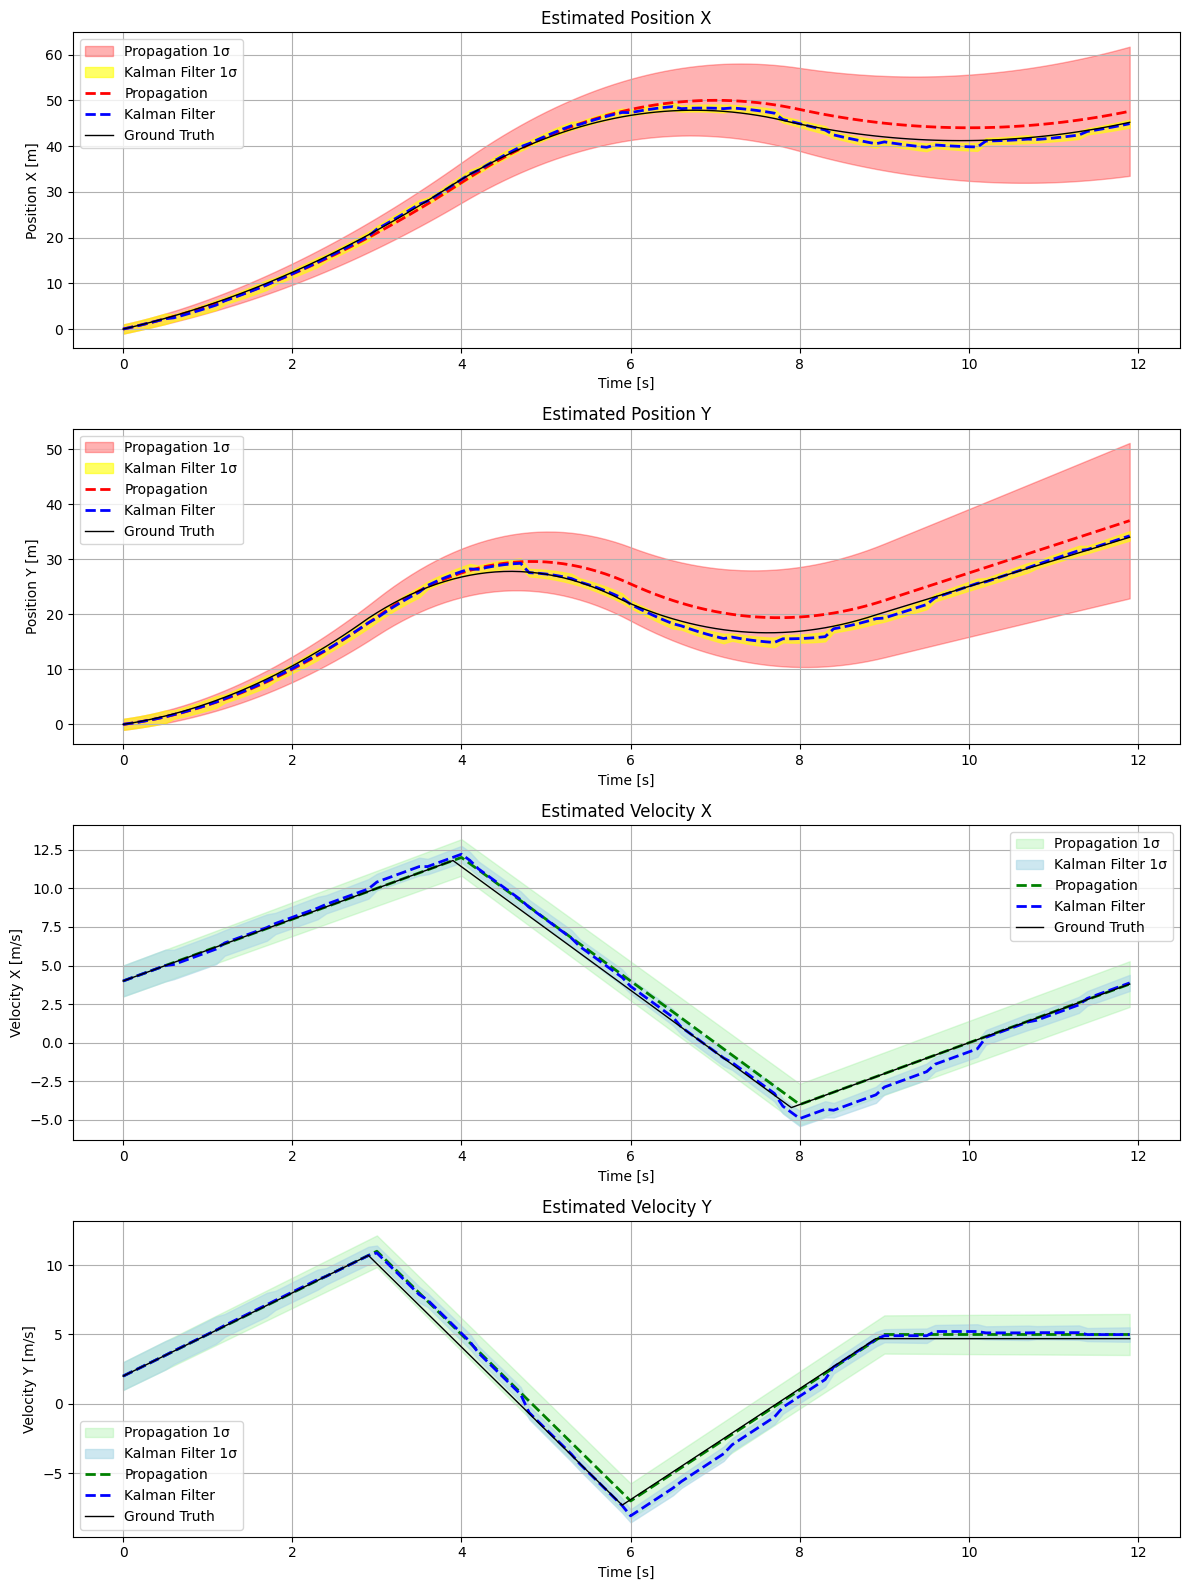

=== 불확실성(공분산) 진화 분석 ===


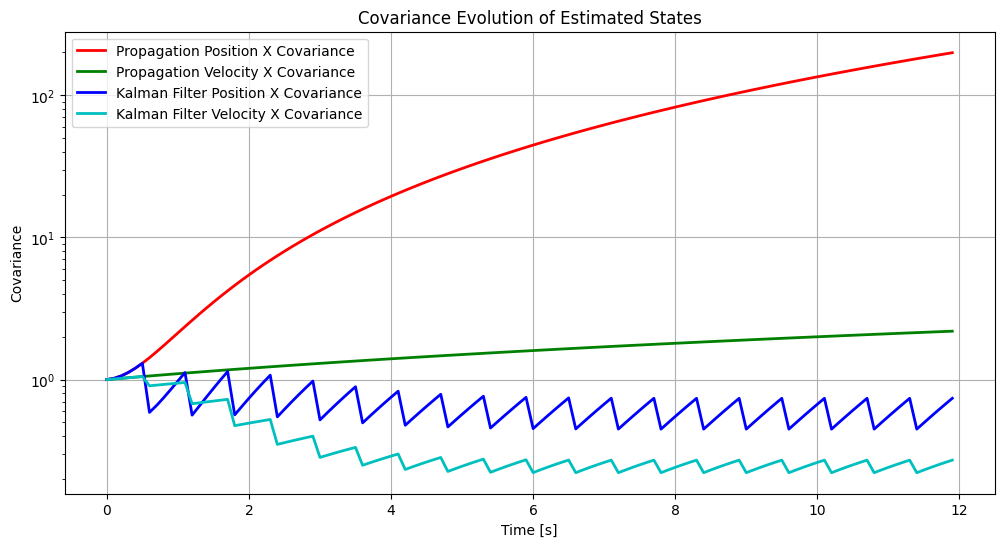

In [18]:
# 추정 결과 상세 분석
print("=== 상태 추정 결과 시각화 ===")
visualizer.plot_estimation_results(sim_data, results)

# 공분산 진화 분석
print("=== 불확실성(공분산) 진화 분석 ===")
visualizer.plot_covariance_evolution(sim_data, results)


## 5. 공분산 타원을 이용한 2D 시각화

공분산 타원은 추정된 위치의 불확실성을 2D 평면에서 시각적으로 표현합니다. 
타원의 크기와 방향은 위치 불확실성의 크기와 상관관계를 나타냅니다.

=== 공분산 타원 시각화 (여러 시점) ===


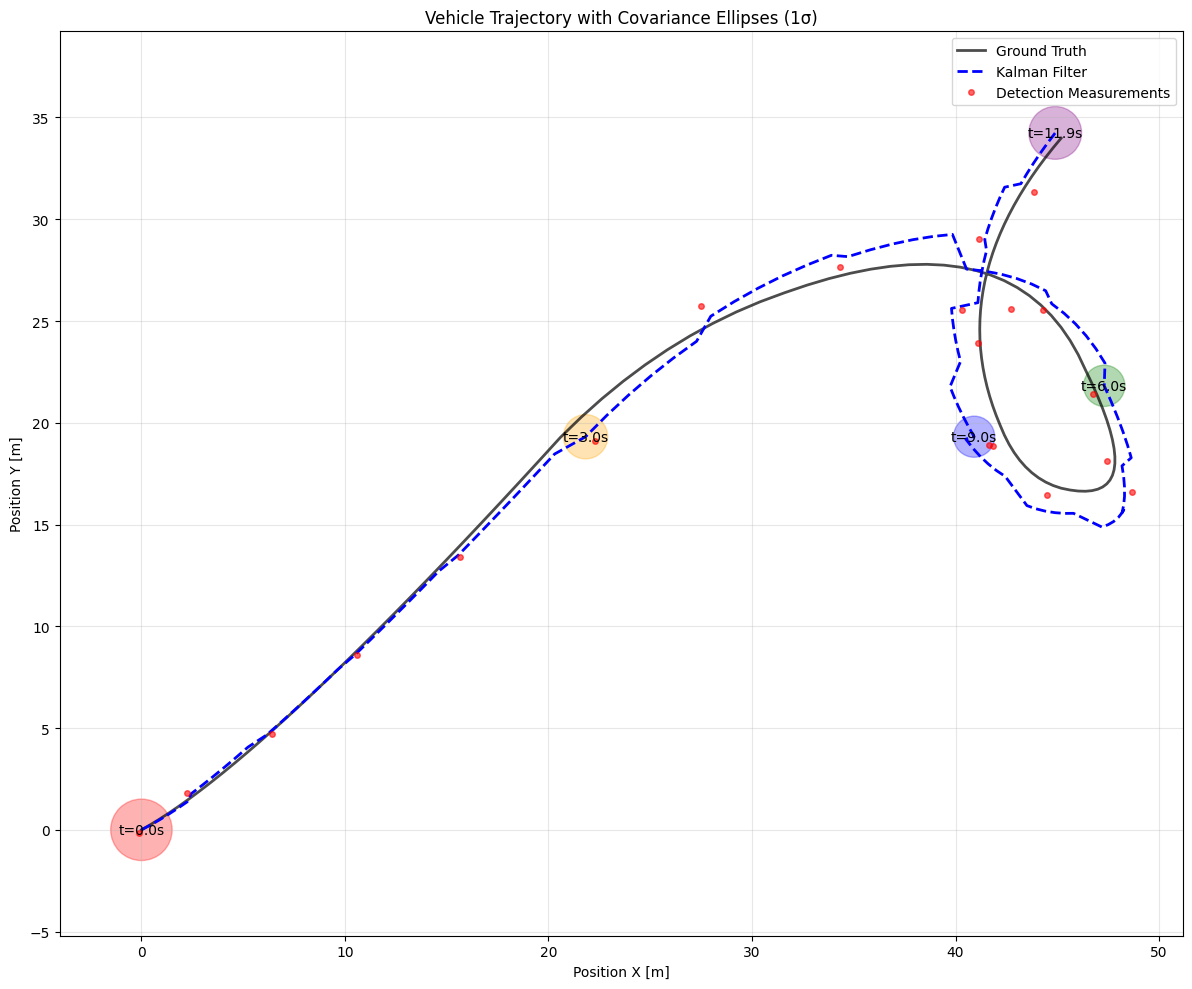

🔍 공분산 타원 해석:
- 타원의 크기: 위치 불확실성의 크기
- 타원의 방향: 불확실성의 주축 방향
- 측정 업데이트 후: 타원이 작아짐 (불확실성 감소)
- 예측 단계: 타원이 커짐 (불확실성 증가)


In [19]:
# 특정 시점에서의 공분산 타원 시각화
print("=== 공분산 타원 시각화 (여러 시점) ===")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# 실제 궤적
ax.plot(sim_data['position_x'], sim_data['position_y'], 'k-', linewidth=2, label='Ground Truth', alpha=0.7)

# 칼만 필터 추정 궤적
ax.plot(results['x_kalman'][0, :], results['x_kalman'][1, :], 'b--', linewidth=2, label='Kalman Filter')

# 인지 센서 측정값
interval = sim_data['detection_update_interval']
detection_indices = np.arange(0, len(sim_data['time']), interval)
ax.plot(sim_data['detection_measurement_x'][detection_indices], 
        sim_data['detection_measurement_y'][detection_indices], 
        'ro', markersize=4, label='Detection Measurements', alpha=0.6)

# 여러 시점에서의 공분산 타원 표시
time_points = [0, 30, 60, 90, 119]  # 인덱스
colors = ['red', 'orange', 'green', 'blue', 'purple']

for i, (time_idx, color) in enumerate(zip(time_points, colors)):
    if time_idx < len(sim_data['time']):
        center = results['x_kalman'][:2, time_idx]
        cov_matrix = results['P_kalman'][:2, :2, time_idx]
        
        ellipse = visualizer.plot_covariance_ellipse(
            center, cov_matrix, n_sigma=1.0,
            facecolor=color, edgecolor=color, alpha=0.3
        )
        ax.add_patch(ellipse)
        
        # 시간 라벨
        ax.text(center[0], center[1], f't={sim_data["time"][time_idx]:.1f}s', 
                fontsize=10, ha='center', va='center')

ax.set_xlabel('Position X [m]')
ax.set_ylabel('Position Y [m]')
ax.set_title('Vehicle Trajectory with Covariance Ellipses (1σ)')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axis('equal')

plt.tight_layout()
plt.show()

print("🔍 공분산 타원 해석:")
print("- 타원의 크기: 위치 불확실성의 크기")
print("- 타원의 방향: 불확실성의 주축 방향")
print("- 측정 업데이트 후: 타원이 작아짐 (불확실성 감소)")
print("- 예측 단계: 타원이 커짐 (불확실성 증가)")

## 6. 애니메이션으로 보는 칼만 필터 동작

이제 칼만 필터의 동작을 실시간으로 관찰할 수 있는 애니메이션을 만들어보겠습니다.

### 애니메이션 특징
- **Ground Truth 경로**: 실제 차량 궤적 (검은색)
- **칼만 필터 경로**: 추정된 차량 궤적 (파란색)  
- **현재 위치**: 각 시점에서의 실제/추정 위치
- **속도 벡터**: 화살표로 표시되는 속도 방향과 크기
- **공분산 타원**: 위치 불확실성을 나타내는 1σ 타원
- **측정 업데이트**: 0.6초마다 발생하는 센서 측정 시점

=== 애니메이션 시각화 옵션 ===
1. 실시간 애니메이션 (화면에서만 재생)
2. GIF 파일로 저장
3. MP4 파일로 저장 (ffmpeg 필요)

GIF 애니메이션을 생성합니다...
애니메이션 생성 중... (총 120프레임, 10fps)
애니메이션을 kalman_filter_animation.gif에 저장 중...
✅ 애니메이션 저장 완료!

🎬 애니메이션 관찰 포인트:
- 측정 업데이트 시점에서 공분산 타원이 갑자기 작아지는 현상
- 예측 단계에서 불확실성이 점진적으로 증가하는 모습
- Ground Truth와 칼만 필터 추정값의 차이
- 속도 벡터의 방향과 크기 변화


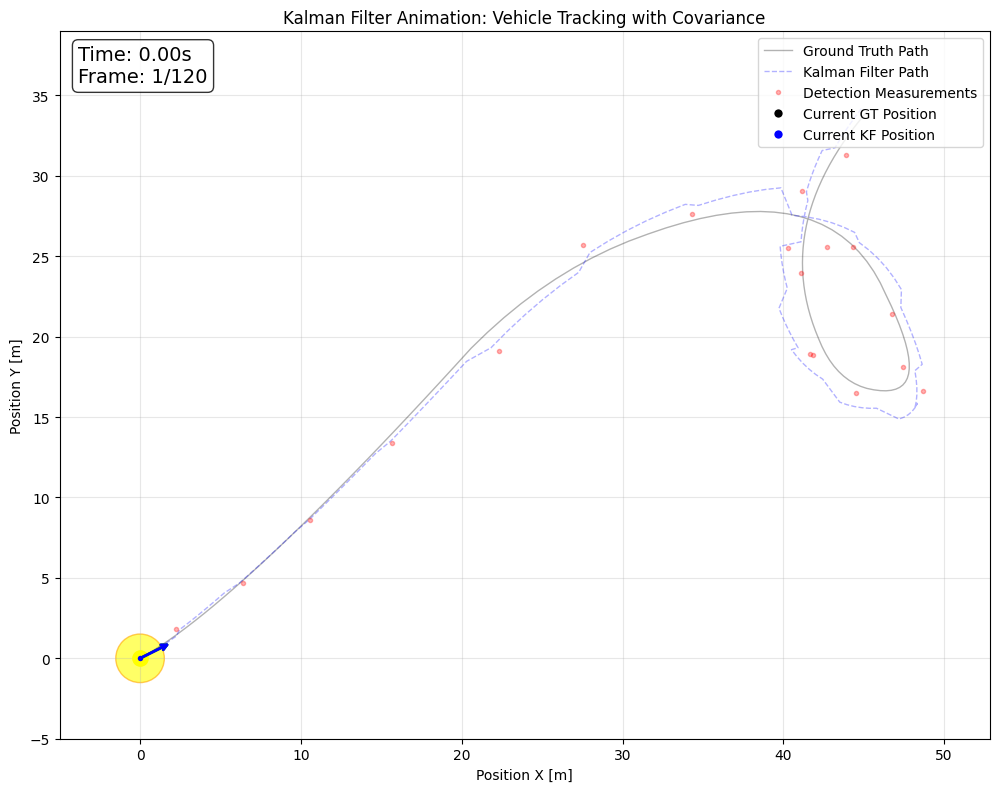

In [ ]:
# 애니메이션 옵션 선택
print("=== 애니메이션 시각화 옵션 ===")
print("1. 실시간 애니메이션 (화면에서만 재생)")
print("2. GIF 파일로 저장")
print("3. MP4 파일로 저장 (ffmpeg 필요)")

# 원하는 옵션을 선택하세요
animation_option = 2  # 1: 실시간, 2: GIF 저장, 3: MP4 저장

if animation_option == 1:
    print("\n실시간 애니메이션을 시작합니다...")
    print("💡 팁: 애니메이션 창을 닫으면 중지됩니다.")
    
    # 실시간 애니메이션 (빠른 재생)
    visualizer.create_simple_animation(sim_data, results, interval_ms=50)
    
elif animation_option == 2:
    print("\nGIF 애니메이션을 생성합니다...")
    
    # GIF로 저장 (10fps)
    anim = visualizer.create_kalman_filter_animation( # x_kalman, p_kalman을 x_propagation, p_propagation으로 변환 가능
        sim_data, results, 
        save_path='kalman_filter_animation.gif', 
        fps=10
    )
    
elif animation_option == 3:
    print("\nMP4 동영상을 생성합니다...")
    # pip install ffmpeg-python 필요
    
    # MP4로 저장 (20fps)
    anim = visualizer.create_kalman_filter_animation(
        sim_data, results, 
        save_path='kalman_filter_animation.mp4', 
        fps=20
    )
    
print("\n🎬 애니메이션 관찰 포인트:")
print("- 측정 업데이트 시점에서 공분산 타원이 갑자기 작아지는 현상")
print("- 예측 단계에서 불확실성이 점진적으로 증가하는 모습") 
print("- Ground Truth와 칼만 필터 추정값의 차이")
print("- 속도 벡터의 방향과 크기 변화")


## 7. 성능 분석 및 결론

### 불안정 시스템에서의 칼만 필터 효과

이 실습을 통해 다음을 확인할 수 있습니다:

#### 1. 단순 전파의 한계
- **불확실성 발산**: 시간이 지남에 따라 위치 불확실성이 계속 증가
- **누적 오차**: 모델 불확실성과 초기 조건 오차가 누적
- **안정성 부족**: 고유값 ≥ 1로 인한 불안정 특성

#### 2. 칼만 필터의 장점
- **불확실성 제어**: 측정 업데이트를 통한 불확실성 감소
- **최적 융합**: 예측과 측정의 신뢰도에 따른 가중 평균
- **안정화 효과**: 주기적 측정을 통한 시스템 안정화

#### 3. 주요 학습 내용
- **예측-업데이트 사이클**: 칼만 필터의 핵심 메커니즘
- **칼만 게인**: 예측과 측정 간의 신뢰도 균형
- **공분산 전파**: 불확실성의 시간 진화
- **Joseph Form**: 수치적 안정성을 위한 공분산 업데이트


In [21]:
# 최종 성능 분석
print("=== 최종 성능 분석 및 통계 ===")

# 전체 시간에 대한 오차 계산
position_errors_prop = np.sqrt((results['x_propagation'][0, :] - sim_data['position_x'])**2 + 
                               (results['x_propagation'][1, :] - sim_data['position_y'])**2)
position_errors_kf = np.sqrt((results['x_kalman'][0, :] - sim_data['position_x'])**2 + 
                            (results['x_kalman'][1, :] - sim_data['position_y'])**2)

velocity_errors_prop = np.sqrt((results['x_propagation'][2, :] - sim_data['velocity_x'])**2 + 
                               (results['x_propagation'][3, :] - sim_data['velocity_y'])**2)
velocity_errors_kf = np.sqrt((results['x_kalman'][2, :] - sim_data['velocity_x'])**2 + 
                            (results['x_kalman'][3, :] - sim_data['velocity_y'])**2)

print(f"📊 위치 추정 오차 통계")
print(f"단순 전파 - 평균: {np.mean(position_errors_prop):.2f}m, 최대: {np.max(position_errors_prop):.2f}m")
print(f"칼만 필터 - 평균: {np.mean(position_errors_kf):.2f}m, 최대: {np.max(position_errors_kf):.2f}m")
print(f"위치 오차 개선: {(np.mean(position_errors_prop) - np.mean(position_errors_kf))/np.mean(position_errors_prop)*100:.1f}%")

print(f"\n📊 속도 추정 오차 통계")
print(f"단순 전파 - 평균: {np.mean(velocity_errors_prop):.2f}m/s, 최대: {np.max(velocity_errors_prop):.2f}m/s")
print(f"칼만 필터 - 평균: {np.mean(velocity_errors_kf):.2f}m/s, 최대: {np.max(velocity_errors_kf):.2f}m/s")
print(f"속도 오차 개선: {(np.mean(velocity_errors_prop) - np.mean(velocity_errors_kf))/np.mean(velocity_errors_prop)*100:.1f}%")

print(f"\n📊 불확실성 분석 (최종 시점)")
final_std_prop_pos = np.sqrt(results['P_propagation'][0, 0, -1])
final_std_kf_pos = np.sqrt(results['P_kalman'][0, 0, -1])
print(f"위치 불확실성 (1σ) - 전파: {final_std_prop_pos:.2f}m, 칼만: {final_std_kf_pos:.2f}m")
print(f"불확실성 감소: {(final_std_prop_pos - final_std_kf_pos)/final_std_prop_pos*100:.1f}%")

print(f"\n🎯 결론:")
print(f"✅ 칼만 필터는 불안정한 차량 시스템에서 측정을 통해 상태 추정 성능을 크게 개선합니다.")
print(f"✅ 주기적인 인지 센서 측정이 위치 불확실성의 발산을 효과적으로 제어합니다.")
print(f"✅ 예측과 측정의 최적 결합으로 단순 전파 대비 우수한 성능을 달성합니다.")

=== 최종 성능 분석 및 통계 ===
📊 위치 추정 오차 통계
단순 전파 - 평균: 2.48m, 최대: 4.14m
칼만 필터 - 평균: 0.88m, 최대: 2.11m
위치 오차 개선: 64.8%

📊 속도 추정 오차 통계
단순 전파 - 평균: 0.44m/s, 최대: 1.08m/s
칼만 필터 - 평균: 0.63m/s, 최대: 1.28m/s
속도 오차 개선: -43.5%

📊 불확실성 분석 (최종 시점)
위치 불확실성 (1σ) - 전파: 14.12m, 칼만: 0.86m
불확실성 감소: 93.9%

🎯 결론:
✅ 칼만 필터는 불안정한 차량 시스템에서 측정을 통해 상태 추정 성능을 크게 개선합니다.
✅ 주기적인 인지 센서 측정이 위치 불확실성의 발산을 효과적으로 제어합니다.
✅ 예측과 측정의 최적 결합으로 단순 전파 대비 우수한 성능을 달성합니다.
